# Parsing from healthylaife pipeline -> Pandas DF -> Pacmed features/confounder list -> pygformula structure  

In [1]:
import numpy as np
import pandas as pd
import pickle
import re, os
import json

In [2]:
data_dic_path = r"C:\Users\snsimha\OneDrive - Amsterdam UMC\Documenten\PhD\Design Trial\Code\Self-pipeline\MIMIC-IV\Dataset_fromcluster\10k\dataDic"
with open(data_dic_path, "rb") as d:
    dataDic = pickle.load(d)

In [3]:
dataDic.keys()

dict_keys([32332612, 37138571, 38229215, 30272674, 30670039, 35818097, 33069153, 32020842, 35735453, 30791561, 31548449, 30010143, 37262588, 33667114, 31409211, 34326531, 34235700, 39095821, 35645684, 30200246, 35732464, 31421209, 31525852, 39876736, 34513403, 33521408, 30167698, 38925473, 32435792, 37875725, 33557621, 35291221, 32718223, 36478227, 38518423, 31753596, 34852392, 33987441, 37739589, 32535225, 36790734, 35515287, 32226065, 32401227, 30998752, 37092788, 32473430, 32630155, 37667374, 30774936, 39329304, 37503273, 35636875, 30526491, 38955189, 36551479, 39136086, 31747890, 36623912, 33392811, 35447664, 34172580, 39345600, 38321993, 35515546, 34657760, 31858997, 31174875, 35371099, 39881507, 32689737, 31818772, 39088372, 37123986, 31599308, 37853395, 37621785, 38783591, 39156786, 39190305, 36539776, 30914952, 37307878, 36582479, 35379061, 30839156, 34354446, 38777874, 39135241, 39043482, 35320607, 36209443, 34729540, 39699735, 38962283, 38055009, 35362807, 34497427, 38241675,

All LOS into a single dataframe

In [4]:
# ---------------------------------------------------------
# Load your data dictionary
# ---------------------------------------------------------
data_dic_path = r"C:\Users\snsimha\OneDrive - Amsterdam UMC\Documenten\PhD\Design Trial\Code\Self-pipeline\MIMIC-IV\Dataset_fromcluster\10k\dataDic"
with open(data_dic_path, "rb") as f:
    dataDic = pickle.load(f)

# ---------------------------------------------------------
# Categorical chart itemids (from your design)
# ---------------------------------------------------------
CATEGORICAL_CHART = {223849, 229314, 227577}

# ---------------------------------------------------------
# Storage for all stays
# ---------------------------------------------------------
all_rows = []

# ---------------------------------------------------------
# Function to expand a dict mapping itemid -> list into a DataFrame
# Produces a DataFrame with columns itemid__suffix
# ---------------------------------------------------------
def expand_feature_dict(feature_dict, suffix):
    """
    feature_dict: {itemid: list_of_values}
    suffix: string to append after itemid (e.g., "val", "val_last")
    
    Returns: DataFrame with columns: f"{itemid}__{suffix}"
    """
    if feature_dict is None:
        return pd.DataFrame()

    out = {}
    for itemid, series in feature_dict.items():
        out[f"{itemid}__{suffix}"] = series
    return pd.DataFrame(out)


# ---------------------------------------------------------
# MAIN LOOP — process each stay
# ---------------------------------------------------------
for stay_id, stay_blob in dataDic.items():

    los = stay_blob["los"]
    T = los  # t=0..los-1

    # -----------------------------
    # 1. Create basic time index
    # -----------------------------
    df = pd.DataFrame({
        "stay_id":   [stay_id] * T,
        "t":         list(range(T)),
        "ethnicity": [stay_blob.get("ethnicity", None)] * T,
        "age":       [stay_blob.get("age", None)] * T,
        "gender":    [stay_blob.get("gender", None)] * T,
        "label":     [stay_blob.get("label", None)] * T,
        "los":       [stay_blob.get("los", None)] * T,
    })

    # -----------------------------
    # 2. CHART variables
    # -----------------------------
    chart = stay_blob.get("Chart", {})

    # numerical: val, val_last, last_time
    df_val       = expand_feature_dict(chart.get("val"), "val")
    df_val_last  = expand_feature_dict(chart.get("val_last"), "val_last")
    df_last_time = expand_feature_dict(chart.get("last_time"), "last_time")

    # categorical: cat_last, cat_last_time
    df_cat_last  = expand_feature_dict(chart.get("cat_last"), "cat_last")
    df_cat_time  = expand_feature_dict(chart.get("cat_last_time"), "cat_last_time")

    # -----------------------------
    # 3. PROCVENT variables
    # -----------------------------
    pv = stay_blob.get("ProcVent", {})

    df_pv_signal     = expand_feature_dict(pv.get("signal"), "signal")
    df_pv_val_last   = expand_feature_dict(pv.get("val_last"), "val_last")
    df_pv_last_time  = expand_feature_dict(pv.get("last_time"), "last_time")

    # -----------------------------
    # 4. Combine all features
    # -----------------------------
    feature_df = pd.concat(
        [
            df,
            df_val, df_val_last, df_last_time,
            df_cat_last, df_cat_time,
            df_pv_signal, df_pv_val_last, df_pv_last_time
        ],
        axis=1
    )

    all_rows.append(feature_df)


# ---------------------------------------------------------
# FINAL OUTPUT: full time-series DataFrame
# ---------------------------------------------------------
sfp_mimicdata = pd.concat(all_rows, ignore_index=True)

print(sfp_mimicdata.shape)
print(sfp_mimicdata.head())


(853248, 71)
    stay_id  t ethnicity  age gender  label  los  220045__val  220210__val  \
0  32332612  0     WHITE   77      F      0   25    85.000000    18.071429   
1  32332612  1     WHITE   77      F      0   25    85.666667    18.250000   
2  32332612  2     WHITE   77      F      0   25    89.000000    18.000000   
3  32332612  3     WHITE   77      F      0   25          NaN          NaN   
4  32332612  4     WHITE   77      F      0   25          NaN          NaN   

   220228__val  ...  227582__val  227287__val_last  227582__val_last  \
0         12.6  ...          NaN               NaN               NaN   
1         12.7  ...          NaN               NaN               NaN   
2          NaN  ...          NaN               NaN               NaN   
3          NaN  ...          NaN               NaN               NaN   
4          NaN  ...          NaN               NaN               NaN   

   227287__last_time  227582__last_time  220052__val  223762__val  \
0               

In [5]:
sfp_mimicdata.stay_id.nunique()

9593

In [6]:
sfp_mimicdata[sfp_mimicdata.stay_id == 32332612]

,stay_id,t,ethnicity,age,gender,label,los,220045__val,220210__val,220228__val,...,227582__val,227287__val_last,227582__val_last,227287__last_time,227582__last_time,220052__val,223762__val,226631__val,226561__val,226329__val
0,32332612,0,WHITE,77,F,0,25,85.000000,18.071429,12.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32332612,1,WHITE,77,F,0,25,85.666667,18.250000,12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32332612,2,WHITE,77,F,0,25,89.000000,18.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32332612,3,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32332612,4,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,32332612,5,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,32332612,6,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,32332612,7,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,32332612,8,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,32332612,9,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sfp_mimicdata.columns

Index(['stay_id', 't', 'ethnicity', 'age', 'gender', 'label', 'los',
       '220045__val', '220210__val', '220228__val', '220277__val',
       '220615__val', '220739__val', '223761__val', '223834__val',
       '223900__val', '223901__val', '225624__val', '226560__val',
       '227443__val', '227466__val', '220228__val_last', '220615__val_last',
       '220739__val_last', '223834__val_last', '223900__val_last',
       '223901__val_last', '225624__val_last', '227443__val_last',
       '227466__val_last', '220228__last_time', '220615__last_time',
       '220739__last_time', '223834__last_time', '223900__last_time',
       '223901__last_time', '225624__last_time', '227443__last_time',
       '227466__last_time', '223849__cat_last', '227577__cat_last',
       '229314__cat_last', '223849__cat_last_time', '227577__cat_last_time',
       '229314__cat_last_time', '225792__signal', '225794__signal',
       '225792__val_last', '225794__val_last', '225792__last_time',
       '225794__last_time', '

In [8]:
len(sfp_mimicdata.columns)

71

# Make a copy so as to make further changes to dataframe

In [9]:
sf_mimicdata = sfp_mimicdata.copy()

In [10]:
# Load JSON file
with open("mappings.json", "r") as f:
    mappings_raw = json.load(f)

# Convert keys to strings (important!)
mappings = {
    section: {str(k): v for k, v in mapping.items()}
    for section, mapping in mappings_raw.items()
}

# Your dataframe
df = sf_mimicdata.copy()

# Itemids that are categorical (CHART ventilator modes)
categorical_modes = {"223849", "229314", "227577"}

# Build a renaming dictionary
rename_dict = {}

# ---------------------------------------------------------
# 1) Process CHART mappings
# ---------------------------------------------------------
for itemid_str, new_name in mappings["Chart"].items():
    itemid = itemid_str  # keep as string because df columns are strings

    # --- Case A: mean over last 12h ---
    if new_name.endswith("__mean__last_12h"):
        old_col = f"{itemid}__val"
        if old_col in df.columns:
            rename_dict[old_col] = new_name

    # --- Case B: last-known over last 12h ---
    elif new_name.endswith("__last__last_12h"):

        # Categorical (special treatment)
        if itemid_str in categorical_modes:
            old_last  = f"{itemid}__cat_last"
            old_time  = f"{itemid}__cat_last_time"

        # Numeric
        else:
            old_last  = f"{itemid}__val_last"
            old_time  = f"{itemid}__last_time"

        # Only rename if column exists
        if old_last in df.columns:
            rename_dict[old_last] = new_name     # rename LAST VALUE
        if old_time in df.columns:
            rename_dict[old_time] = new_name.replace("__last__", "__time__")  
            # rename TIME column

# ---------------------------------------------------------
# 2) Process PROCVENT mappings
# ---------------------------------------------------------
for itemid_str, new_name in mappings["ProcVent"].items():
    itemid = itemid_str

    # last-known value
    old_last = f"{itemid}__val_last"
    if old_last in df.columns:
        rename_dict[old_last] = new_name

    # last-known timestamp
    old_time = f"{itemid}__last_time"
    if old_time in df.columns:
        rename_dict[old_time] = new_name.replace("__last__", "__time__")

    # ventilation signal (binary)
    old_sig = f"{itemid}__signal"
    if old_sig in df.columns:
        rename_dict[old_sig] = new_name.replace("__last__", "__signal__")

# ---------------------------------------------------------
# 3) Apply the renaming
# ---------------------------------------------------------
df = df.rename(columns=rename_dict)

# Done
print("Renamed columns:")
for old, new in rename_dict.items():
    print(f"{old} → {new}")

sf_mimicdata = df.copy()


Renamed columns:
227443__val_last → bicarbonate_arterial__last__last_12h
227443__last_time → bicarbonate_arterial__time__last_12h
227466__val_last → activated_partial_thromboplastin_time__last__last_12h
227466__last_time → activated_partial_thromboplastin_time__time__last_12h
223762__val → temperature__mean__last_12h
223761__val → temperature_F__mean__last_12h
226329__val → temperature_S__mean__last_12h
220228__val_last → hemoglobin__last__last_12h
220228__last_time → hemoglobin__time__last_12h
220045__val → heart_rate__mean__last_12h
220052__val → arterial_blood_pressure_mean__mean__last_12h
220615__val_last → creatinine__last__last_12h
220615__last_time → creatinine__time__last_12h
225624__val_last → ureum__last__last_12h
225624__last_time → ureum__time__last_12h
226561__val → fluid_out_urine_CC__mean__last_12h
226559__val → fluid_out_urine_FO__mean__last_12h
226627__val → fluid_out_urine_OR__mean__last_12h
226631__val → fluid_out_urine_PACU__mean__last_12h
226567__val → fluid_out_ur

In [11]:
len(sf_mimicdata.columns)

71

In [12]:
sf_mimicdata.columns

Index(['stay_id', 't', 'ethnicity', 'age', 'gender', 'label', 'los',
       'heart_rate__mean__last_12h',
       'respiratory_rate_measured_nurse__mean__last_12h', '220228__val',
       'o2_saturation__mean__last_12h', '220615__val', '220739__val',
       'temperature_F__mean__last_12h', '223834__val', '223900__val',
       '223901__val', '225624__val', 'fluid_out_urine_V__mean__last_12h',
       '227443__val', '227466__val', 'hemoglobin__last__last_12h',
       'creatinine__last__last_12h', 'glasgow_coma_scale_eye__last__last_12h',
       'o2_flow_generic__last__last_12h',
       'glasgow_coma_scale_verbal__last__last_12h',
       'glasgow_coma_scale_motor__last__last_12h', 'ureum__last__last_12h',
       'bicarbonate_arterial__last__last_12h',
       'activated_partial_thromboplastin_time__last__last_12h',
       'hemoglobin__time__last_12h', 'creatinine__time__last_12h',
       'glasgow_coma_scale_eye__time__last_12h',
       'o2_flow_generic__time__last_12h',
       'glasgow_coma_s

In [13]:
sf_mimicdata.stay_id.nunique()

9593

In [14]:
sf_mimicdata.los.unique()

array([  25,   99,  242,   75,   33,   68,   40,   15,   18,   21,   89,
        116,   69,  109,   49,   31,   19,   20,   29,   16,  617,   76,
         28,   26,   93,  144,   13,   14,   53,  118,   73,   51,   86,
         24,   46,   59,  160,  208,   30,  141,   54,   34,   88,  179,
         27,  191,   56,   37,   85,  531,   60,  468,   44,  101,   23,
        149,  846,  560,  181,   41,  198,  154,   87,   17,  200,   92,
         67,  127,  547,   91,   43,   81,   32,  545,  454,   36,   77,
         64,   48, 1802,  183,  161,   95,  197,   63,  120,   82,   42,
         97,  256, 1337,  139,   39,  260,   96,  479,  112,   50,  377,
        124,  168,   61,   71,   65,  190,   45,   38,  145,  106,   79,
        383,  819,  157,  235,  604,  133,  173,   35,   58,  151,  167,
        219,  194,   22,   72,  234,  123,  130,  129,  103,  251,  223,
         78,  236,  111,  153,  155,  210,  213,  122,   47,  878,  174,
        104,  187,  188,   70,  163,  216,  162,  3

In [15]:
sf_mimicdata.los.min()

12

In [16]:
sf_mimicdata.los.max()

2112

<Axes: >

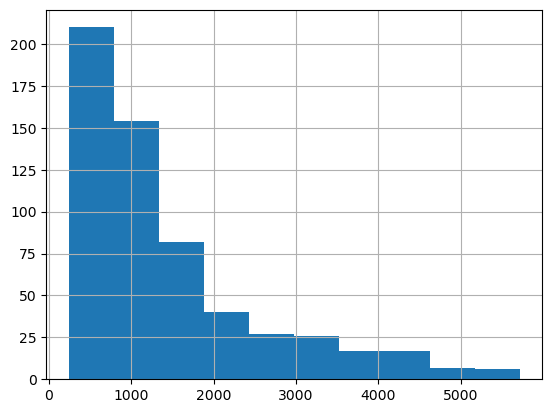

In [17]:
sf_mimicdata.los.value_counts().hist()

In [18]:
for col in sf_mimicdata.columns:
    print(col)

stay_id
t
ethnicity
age
gender
label
los
heart_rate__mean__last_12h
respiratory_rate_measured_nurse__mean__last_12h
220228__val
o2_saturation__mean__last_12h
220615__val
220739__val
temperature_F__mean__last_12h
223834__val
223900__val
223901__val
225624__val
fluid_out_urine_V__mean__last_12h
227443__val
227466__val
hemoglobin__last__last_12h
creatinine__last__last_12h
glasgow_coma_scale_eye__last__last_12h
o2_flow_generic__last__last_12h
glasgow_coma_scale_verbal__last__last_12h
glasgow_coma_scale_motor__last__last_12h
ureum__last__last_12h
bicarbonate_arterial__last__last_12h
activated_partial_thromboplastin_time__last__last_12h
hemoglobin__time__last_12h
creatinine__time__last_12h
glasgow_coma_scale_eye__time__last_12h
o2_flow_generic__time__last_12h
glasgow_coma_scale_verbal__time__last_12h
glasgow_coma_scale_motor__time__last_12h
ureum__time__last_12h
bicarbonate_arterial__time__last_12h
activated_partial_thromboplastin_time__time__last_12h
vent_mode_ventilator_mode__last__last_12

# Matching mortality_within_7days_after_discharge

In [19]:
cohort = pd.read_csv("C:/Users/snsimha/OneDrive - Amsterdam UMC/Documenten/PhD/Design Trial/Datasets/MIMIC-IV/MIMIC-IV-Data-Pipeline/data/LOS-dicts-xdays-12hrs/equal-include_time/4_in-icu_mortality/cohort_icu_mortality_0_.csv.gz")
# Convert to datetimes
cohort = cohort.copy()
cohort["outtime"] = pd.to_datetime(cohort["outtime"], errors="coerce")
cohort["dod"]     = pd.to_datetime(cohort["dod"], errors="coerce")

# 2) Build the 7-day post-ICU discharge mortality indicator at the *stay* level
#    Logic: death recorded, occurs strictly AFTER ICU outtime, and within 7 days of outtime.
cohort["mortality_within_7days_after_discharge"] = (
    cohort["dod"].notna()
    & (cohort["dod"] > cohort["outtime"])
    & (cohort["dod"] <= cohort["outtime"] + pd.Timedelta(days=7))
).astype(int)

# 3) Keep only the stay_ids that are present in sf_mimicdata
final_stay_ids = sf_mimicdata["stay_id"].unique()
df = (
    cohort.loc[cohort["stay_id"].isin(final_stay_ids), ["stay_id", "mortality_within_7days_after_discharge", "subject_id", "intime", "outtime", "insurance"]]
    .drop_duplicates(subset=["stay_id"])  # defensive: ensure unique stay_id rows
    .reset_index(drop=True)
)

print(df.head())

    stay_id  mortality_within_7days_after_discharge  subject_id  \
0  31573075                                       0    10002667   
1  35629889                                       0    10002930   
2  30213599                                       0    10004606   
3  34629895                                       0    10005348   
4  36496303                                       0    10005909   

                intime             outtime insurance  
0  2187-02-23 16:02:25 2187-02-25 14:53:11   Private  
1  2198-04-17 21:24:00 2198-04-18 13:41:43  Medicare  
2  2159-02-20 16:10:03 2159-02-25 20:09:14   Private  
3  2130-10-27 12:06:00 2130-10-29 12:05:02  Medicare  
4  2144-10-29 23:09:03 2144-11-02 15:24:29   Private  


In [20]:
# 3.09% 
s = df.mortality_within_7days_after_discharge.value_counts()
s[1]/s.sum()

0.034400083394141565

In [21]:
# Merge the mortality label into sf_mimicdata
sf_mimicdata = sf_mimicdata.merge(
    df[["stay_id", "mortality_within_7days_after_discharge", "subject_id", "intime", "outtime", "insurance"]],
    on="stay_id",
    how="left"
)

In [22]:
#ratio of mortality
last_rows = sf_mimicdata.groupby("stay_id").tail(1)
(last_rows["mortality_within_7days_after_discharge"] == 1).mean()

0.034400083394141565

In [23]:
#in-icu mortality
last_rows = sf_mimicdata.groupby("stay_id").tail(1)
(last_rows["label"] == 1).mean()

0.07432502866673617

In [24]:
sf_mimicdata.describe()

,stay_id,t,age,label,los,heart_rate__mean__last_12h,respiratory_rate_measured_nurse__mean__last_12h,220228__val,o2_saturation__mean__last_12h,220615__val,...,o2_flow_cannula__time__last_12h,o2_flow_bipap__time__last_12h,arterial_blood_pressure_mean__mean__last_12h,temperature__mean__last_12h,fluid_out_urine_PACU__mean__last_12h,fluid_out_urine_CC__mean__last_12h,temperature_S__mean__last_12h,mortality_within_7days_after_discharge,subject_id,outtime
count,8.532480e+05,853248.000000,853248.000000,853248.000000,853248.000000,74837.000000,74330.000000,44382.000000,7.453800e+04,48750.000000,...,2073.000000,704.000000,25427.000000,4574.000000,261.000000,2815.000000,1400.000000,853248.000000,8.532480e+05,853248
mean,3.498433e+07,137.554614,62.637240,0.126642,276.109227,85.737187,20.053111,67.938886,1.169077e+02,32.328941,...,86.580801,103.576705,79.635053,37.486909,1095.769476,293.109969,37.271825,0.044421,1.492047e+07,2154-01-08 00:21:35.389071360
min,3.000166e+07,0.000000,18.000000,0.000000,12.000000,0.000000,0.000000,2.850000,-7.918142e+04,0.000000,...,0.000000,0.000000,-36.000000,0.000000,0.000000,0.000000,28.986667,0.000000,1.000267e+07,2110-01-21 18:40:48
25%,3.252798e+07,23.000000,53.000000,0.000000,68.000000,74.000000,16.750000,8.200000,9.533333e+01,0.700000,...,20.000000,13.000000,70.692308,36.500000,350.000000,166.666667,36.632692,0.000000,1.241768e+07,2134-09-17 14:33:24.999999488
50%,3.496895e+07,61.000000,64.000000,0.000000,150.000000,84.533333,19.461538,9.400000,9.691667e+01,1.000000,...,45.000000,46.000000,77.333333,37.028992,650.000000,250.000000,37.100000,0.000000,1.488709e+07,2154-01-02 18:55:22
75%,3.745642e+07,160.000000,74.000000,0.000000,352.000000,96.500000,22.750000,10.900000,9.842857e+01,1.800000,...,98.000000,106.000000,86.500000,37.577778,1350.000000,383.333333,37.525000,0.000000,1.743637e+07,2174-08-05 19:23:16
max,3.999929e+07,2111.000000,91.000000,1.000000,2112.000000,527.500000,543.666667,500004.950000,1.387228e+06,500000.350000,...,1397.000000,1025.000000,619.916667,100.900000,8130.000000,1600.000000,98.700000,1.000000,1.999929e+07,2213-05-26 15:26:46
std,2.879674e+06,207.518377,16.032013,0.332572,331.862595,16.569455,5.106820,5141.988655,5.116060e+03,3922.230160,...,128.610361,161.106027,15.979596,5.424812,1205.014859,189.987235,3.214447,0.206028,2.882174e+06,NaN


In [25]:
sf_mimicdata.columns

Index(['stay_id', 't', 'ethnicity', 'age', 'gender', 'label', 'los',
       'heart_rate__mean__last_12h',
       'respiratory_rate_measured_nurse__mean__last_12h', '220228__val',
       'o2_saturation__mean__last_12h', '220615__val', '220739__val',
       'temperature_F__mean__last_12h', '223834__val', '223900__val',
       '223901__val', '225624__val', 'fluid_out_urine_V__mean__last_12h',
       '227443__val', '227466__val', 'hemoglobin__last__last_12h',
       'creatinine__last__last_12h', 'glasgow_coma_scale_eye__last__last_12h',
       'o2_flow_generic__last__last_12h',
       'glasgow_coma_scale_verbal__last__last_12h',
       'glasgow_coma_scale_motor__last__last_12h', 'ureum__last__last_12h',
       'bicarbonate_arterial__last__last_12h',
       'activated_partial_thromboplastin_time__last__last_12h',
       'hemoglobin__time__last_12h', 'creatinine__time__last_12h',
       'glasgow_coma_scale_eye__time__last_12h',
       'o2_flow_generic__time__last_12h',
       'glasgow_coma_s

In [26]:
sf_mimicdata.head()

,stay_id,t,ethnicity,age,gender,label,los,heart_rate__mean__last_12h,respiratory_rate_measured_nurse__mean__last_12h,220228__val,...,arterial_blood_pressure_mean__mean__last_12h,temperature__mean__last_12h,fluid_out_urine_PACU__mean__last_12h,fluid_out_urine_CC__mean__last_12h,temperature_S__mean__last_12h,mortality_within_7days_after_discharge,subject_id,intime,outtime,insurance
0,32332612,0,WHITE,77,F,0,25,85.000000,18.071429,12.6,...,NaN,NaN,NaN,NaN,NaN,0,11061117,2122-02-16 15:46:50,2122-02-17 17:09:20,Medicare
1,32332612,1,WHITE,77,F,0,25,85.666667,18.250000,12.7,...,NaN,NaN,NaN,NaN,NaN,0,11061117,2122-02-16 15:46:50,2122-02-17 17:09:20,Medicare
2,32332612,2,WHITE,77,F,0,25,89.000000,18.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0,11061117,2122-02-16 15:46:50,2122-02-17 17:09:20,Medicare
3,32332612,3,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,11061117,2122-02-16 15:46:50,2122-02-17 17:09:20,Medicare
4,32332612,4,WHITE,77,F,0,25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,11061117,2122-02-16 15:46:50,2122-02-17 17:09:20,Medicare


In [27]:
#sf_mimicdata.to_csv('C:/Users/snsimha/OneDrive - Amsterdam UMC/Documenten/PhD/Design Trial/Datasets/MIMIC-IV/MIMIC-IV-Data-Pipeline/data/LOS-dicts-xdays-12hrs/equal-include_time/in-icu_mortality/MIMICIV_LOS7_SelfPipeline_M7D.csv', index=False)

# Arranging variables according to Pacmed's pipeline order

In [28]:
selected_cols = [
"stay_id", "t", "los", "age", "gender", "ethnicity", "label", "mortality_within_7days_after_discharge", "subject_id", "intime", "outtime", "insurance",
    
    'bicarbonate_arterial__last__last_12h',
    'activated_partial_thromboplastin_time__last__last_12h',
    'temperature__mean__last_12h',


    'hemoglobin__last__last_12h',
    'heart_rate__mean__last_12h',
    'arterial_blood_pressure_mean__mean__last_12h',


    'creatinine__last__last_12h',
    'ureum__last__last_12h',

    'fluid_out_urine_CC__mean__last_12h',
    'fluid_out_urine_FO__mean__last_12h',
    'fluid_out_urine_OR__mean__last_12h',
    'fluid_out_urine_PACU__mean__last_12h',
    'fluid_out_urine_SC__mean__last_12h',
    'fluid_out_urine_V__mean__last_12h',

    'lactate__last__last_12h',

    
    'glasgow_coma_scale_eye__last__last_12h',
    'glasgow_coma_scale_verbal__last__last_12h',
    'glasgow_coma_scale_motor__last__last_12h',

    
    'pco2_arterial__mean__last_12h',

    'respiratory_rate_measured_nurse__mean__last_12h',
    'respiratory_rate_measured_total_machine__mean__last_12h',

    'o2_saturation__mean__last_12h',

    'o2_flow_bipap__last__last_12h', 'o2_flow_bipap__time__last_12h',
    'o2_flow_generic__last__last_12h', 'o2_flow_generic__time__last_12h',
    'o2_flow_cannula__last__last_12h', 'o2_flow_cannula__time__last_12h',   

    'po2_arterial__mean__last_12h',

    'vent_mode_inv__last__last_12h', 'vent_mode_inv__time__last_12h',
    'vent_mode_ninv__last__last_12h', 'vent_mode_ninv__time__last_12h',

    'vent_mode_ventilator_mode__last__last_12h', 'vent_mode_ventilator_mode__time__last_12h',
    'vent_mode_ventilator_mode_hamilton__last__last_12h', 'vent_mode_ventilator_mode_hamilton__time__last_12h',
    'vent_mode_bipap_mode__last__last_12h', 'vent_mode_bipap_mode__time__last_12h'
]

sf_mimicdata = sf_mimicdata[selected_cols]

In [29]:
sf_mimicdata.columns

Index(['stay_id', 't', 'los', 'age', 'gender', 'ethnicity', 'label',
       'mortality_within_7days_after_discharge', 'subject_id', 'intime',
       'outtime', 'insurance', 'bicarbonate_arterial__last__last_12h',
       'activated_partial_thromboplastin_time__last__last_12h',
       'temperature__mean__last_12h', 'hemoglobin__last__last_12h',
       'heart_rate__mean__last_12h',
       'arterial_blood_pressure_mean__mean__last_12h',
       'creatinine__last__last_12h', 'ureum__last__last_12h',
       'fluid_out_urine_CC__mean__last_12h',
       'fluid_out_urine_FO__mean__last_12h',
       'fluid_out_urine_OR__mean__last_12h',
       'fluid_out_urine_PACU__mean__last_12h',
       'fluid_out_urine_SC__mean__last_12h',
       'fluid_out_urine_V__mean__last_12h', 'lactate__last__last_12h',
       'glasgow_coma_scale_eye__last__last_12h',
       'glasgow_coma_scale_verbal__last__last_12h',
       'glasgow_coma_scale_motor__last__last_12h',
       'pco2_arterial__mean__last_12h',
       'res

## vent status (inv/ninv)

In [30]:
sf_mimicdata.vent_mode_inv__last__last_12h.value_counts(dropna=False)

vent_mode_inv__last__last_12h
NaN    847361
0.0      3299
1.0      2588
Name: count, dtype: int64

In [31]:
sf_mimicdata.vent_mode_ninv__last__last_12h.value_counts(dropna=False)

vent_mode_ninv__last__last_12h
NaN    852745
0.0       304
1.0       199
Name: count, dtype: int64

In [32]:
'''If INV has the latest timestamp:

1 → "inv", 0 → "no_vent", NaN → "unknown".

If NIV has the latest timestamp:

1 → "ninv", 0 → "no_vent", NaN → "unknown".

If both timestamps are equal:

Prefer "inv" if inv_last==1; else "ninv" if ninv_last==1;

if both 0 → "no_vent"; otherwise "unknown".

If both timestamps are NaN, then "unknown" (no recent information).'''


inv_last = sf_mimicdata["vent_mode_inv__last__last_12h"]      # 1(on)/0(off)/NaN
ninv_last = sf_mimicdata["vent_mode_ninv__last__last_12h"]     # 1(on)/0(off)/NaN
inv_time = sf_mimicdata["vent_mode_inv__time__last_12h"]       # timestamp of last INV status
ninv_time = sf_mimicdata["vent_mode_ninv__time__last_12h"]     # timestamp of last NIV status

# Decide which source has the latest timestamp (row-wise)
# - choose_inv: INV is more recent (or NIV has no timestamp)
# - choose_ninv: NIV is more recent (or INV has no timestamp)
# - tie: both timestamps are equal and not NaN
choose_inv  = inv_time.gt(ninv_time) | ninv_time.isna()
choose_ninv = ninv_time.gt(inv_time) | inv_time.isna()
tie         = inv_time.eq(ninv_time) & inv_time.notna()

# Initialize as 'unknown' by default
sf_mimicdata["vent_status__last__last_12h"] = "unknown"

# --- If INV is the most recent (and not a tie) ---
# If INV last status is 1 -> 'inv'
sf_mimicdata.loc[choose_inv & ~tie & (inv_last == 1), "vent_status__last__last_12h"] = "inv"
# If INV last status is 0 -> explicitly 'no_vent'
sf_mimicdata.loc[choose_inv & ~tie & (inv_last == 0), "vent_status__last__last_12h"] = "no_vent"

# --- If NIV is the most recent (and not a tie) ---
# If NIV last status is 1 -> 'ninv'
sf_mimicdata.loc[choose_ninv & ~tie & (ninv_last == 1), "vent_status__last__last_12h"] = "ninv"
# If NIV last status is 0 -> explicitly 'no_vent'
sf_mimicdata.loc[choose_ninv & ~tie & (ninv_last == 0), "vent_status__last__last_12h"] = "no_vent"

# --- Ties (same timestamp for INV and NIV) ---
# Prefer INV if it's on; else NIV if it's on; else decide off vs unknown
sf_mimicdata.loc[tie & (inv_last == 1), "vent_status__last__last_12h"] = "inv"
sf_mimicdata.loc[tie & (inv_last != 1) & (ninv_last == 1), "vent_status__last__last_12h"] = "ninv"
sf_mimicdata.loc[tie & (inv_last == 0) & (ninv_last == 0), "vent_status__last__last_12h"] = "no_vent"

# (Optional) If you prefer a categorical dtype for memory/speed:
sf_mimicdata["vent_status__last__last_12h"] = sf_mimicdata["vent_status__last__last_12h"].astype("category")

In [33]:
sf_mimicdata.vent_status__last__last_12h.value_counts()

vent_status__last__last_12h
unknown    846956
no_vent      3514
inv          2586
ninv          192
Name: count, dtype: int64

# vent_mode

In [34]:
sf_mimicdata.vent_mode_ventilator_mode__last__last_12h.value_counts(dropna=False)

vent_mode_ventilator_mode__last__last_12h
NaN                    838191
CPAP/PSV                 7276
CMV/ASSIST/AutoFlow      5308
Standby                   945
MMV/PSV/AutoFlow          545
CMV/ASSIST                497
PCV+Assist                117
MMV/PSV                    59
CPAP                       58
CMV                        47
APRV                       46
SIMV/PSV/AutoFlow          40
CPAP/PPS                   37
CMV/AutoFlow               20
SIMV/PSV                   18
PCV+/PSV                   14
PCV+                        9
MMV                         9
SIMV                        6
MMV/AutoFlow                3
Apnea Ventilation           3
Name: count, dtype: int64

In [35]:
sf_mimicdata.vent_mode_ventilator_mode_hamilton__last__last_12h.value_counts(dropna=False)

vent_mode_ventilator_mode_hamilton__last__last_12h
NaN           839625
SPONT           6561
APV (cmv)       5406
ASV              960
P-CMV            227
Ambient          164
VS               125
NIV               95
(S) CMV           51
APRV              20
APV (simv)         7
NIV-ST             4
SIMV               1
P-SIMV             1
DuoPaP             1
Name: count, dtype: int64

In [36]:
sf_mimicdata.vent_mode_bipap_mode__last__last_12h.value_counts(dropna=False)

vent_mode_bipap_mode__last__last_12h
NaN    853248
Name: count, dtype: int64

# Combine into vent_mode

# Time and mode columns
mode_cols = [
    "vent_mode_ventilator_mode__last__last_12h",
    "vent_mode_ventilator_mode_hamilton__last__last_12h"
]

time_cols = [
    "vent_mode_ventilator_mode__time__last_12h",
    "vent_mode_ventilator_mode_hamilton__time__last_12h"
]

# Extract arrays
times = sf_mimicdata[time_cols].to_numpy()
modes = sf_mimicdata[mode_cols].to_numpy()

# 1. Identify rows where *both* timestamps are NaN
all_nan = np.isnan(times).all(axis=1)

# 2. Replace NaNs with -inf so argmax can run safely
times_safe = np.where(np.isnan(times), -np.inf, times)

# 3. Compute index of max time per row
max_idx = np.argmax(times_safe, axis=1)

# 4. Select mode based on latest timestamp
sf_mimicdata["vent_mode__last__last_12h"] = modes[np.arange(len(modes)), max_idx]

# 5. Reassign NaN for rows where all timestamps were missing
sf_mimicdata.loc[all_nan, "vent_mode__last__last_12h"] = np.nan


sf_mimicdata.vent_mode__last__last_12h = sf_mimicdata.vent_mode__last__last_12h.fillna('unknown')

sf_mimicdata.vent_mode__last__last_12h.value_counts(dropna=False)

## vent_mode__hours_since_last

def compute_hours_since_change(df, bucket_size=1):
    df = df.copy()
    df["vent_mode__hours_since_last__last_12h"] = np.nan

    for stay_id, group in df.groupby("stay_id"):
        last_mode = None
        hours_since = 0
        results = []
        for mode in group.sort_values("t")["vent_mode__last__last_12h"]:
            if mode != last_mode:
                hours_since = 0  # reset if mode changed
                last_mode = mode
            else:
                hours_since += bucket_size
            results.append(hours_since)
        df.loc[group.index, "vent_mode__hours_since_last__last_12h"] = results
    return df
    
sf_mimicdata = compute_hours_since_change(sf_mimicdata, bucket_size=12)

def compute_hours_since_last_change(df, bucket_size=12):
    df = df.copy()
    df["vent_mode__hours_since_last__last_12h"] = np.nan

    for stay_id, group in df.groupby("stay_id"):
        group = group.sort_values("t")
        modes = group["vent_mode__last__last_12h"].tolist()

        hours = []
        last_mode = None
        hours_since = 0

        for mode in modes:
            if mode != last_mode:
                # mode changed → reset
                hours_since = 0
                last_mode = mode
            else:
                # same mode → we only know it's between 0 and 12
                hours_since = min(bucket_size, hours_since + bucket_size)

            hours.append(hours_since)

        df.loc[group.index, "vent_mode__hours_since_last__last_12h"] = hours

    return df
sf_mimicdata = compute_hours_since_last_change(sf_mimicdata, bucket_size=12)


In [37]:
def compute_unified_vent_mode_and_hours(df):
    df = df.copy()

    # ======================================================
    # 1. UNIFIED LAST VENT MODE + TIMESTAMP
    # ======================================================

    mode_cols = [
        "vent_mode_ventilator_mode__last__last_12h",
        "vent_mode_ventilator_mode_hamilton__last__last_12h"
    ]
    time_cols = [
        "vent_mode_ventilator_mode__time__last_12h",
        "vent_mode_ventilator_mode_hamilton__time__last_12h"
    ]

    modes = df[mode_cols].to_numpy()
    times = df[time_cols].to_numpy()

    all_nan = np.isnan(times).all(axis=1)
    times_safe = np.where(np.isnan(times), -np.inf, times)
    max_idx = np.argmax(times_safe, axis=1)

    unified_mode = modes[np.arange(len(modes)), max_idx]
    unified_time = times[np.arange(len(times)), max_idx]

    unified_mode[all_nan] = np.nan
    unified_time[all_nan] = np.nan

    # -------------------------
    # NEW STEP: convert NaN → "unknown"
    # -------------------------
    unified_mode = pd.Series(unified_mode).fillna("unknown").to_numpy()
    # -------------------------

    df["vent_mode__last__last_12h"] = unified_mode
    df["vent_mode__time__last_12h"] = unified_time

    # ======================================================
    # 2. FINE-RESOLUTION HOURS SINCE LAST CHANGE
    # ======================================================

    df["vent_mode__hours_since_last__last_12h"] = np.nan

    for stay_id, group in df.groupby("stay_id"):
        group = group.sort_values("t")

        modes = group["vent_mode__last__last_12h"].tolist()
        times = group["vent_mode__time__last_12h"].tolist()

        last_mode = None
        last_event_time = None
        hours_since_list = []

        for idx, (mode, time_val) in enumerate(zip(modes, times)):

            # If no timestamp, fall back to bucket start time
            if pd.isna(time_val):
                bucket_start_time = group.iloc[idx]["t"] * 12
                time_val = bucket_start_time

            if mode != last_mode:
                hours_since_list.append(0)
                last_mode = mode
                last_event_time = time_val
            else:
                hours_since_list.append(max(0, time_val - last_event_time))

        df.loc[group.index, "vent_mode__hours_since_last__last_12h"] = hours_since_list

    return df


# ======================================================
# RUN THE PIPELINE
# ======================================================

sf_mimicdata = compute_unified_vent_mode_and_hours(sf_mimicdata)
#sf_mimicdata["vent_mode__last__last_12h"] = sf_mimicdata["vent_mode__last__last_12h"].fillna("unknown")

print(sf_mimicdata["vent_mode__last__last_12h"].value_counts(dropna=False).head())
print(sf_mimicdata["vent_mode__hours_since_last__last_12h"].describe())


vent_mode__last__last_12h
unknown                824750
CPAP/PSV                 7253
SPONT                    6486
APV (cmv)                5388
CMV/ASSIST/AutoFlow      5295
Name: count, dtype: int64
count    853248.000000
mean       1468.458932
std        2257.622706
min           0.000000
25%         228.000000
50%         636.000000
75%        1704.000000
max       23856.000000
Name: vent_mode__hours_since_last__last_12h, dtype: float64


In [38]:
sf_mimicdata.vent_mode__hours_since_last__last_12h.value_counts(dropna=False)

vent_mode__hours_since_last__last_12h
0.0        21311
12.0       11625
24.0       11236
36.0       10630
48.0       10440
           ...  
23688.0        1
23676.0        1
23664.0        1
23652.0        1
392.0          1
Name: count, Length: 2322, dtype: int64

<Axes: ylabel='Frequency'>

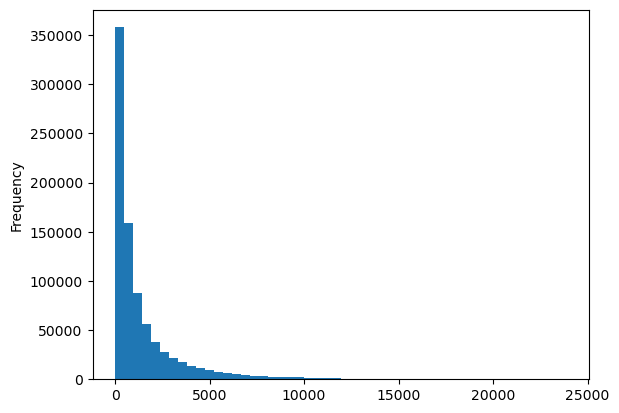

In [39]:
sf_mimicdata.vent_mode__hours_since_last__last_12h.plot.hist(bins=50)

In [40]:
# Mapping from raw categories → derived categories
vent_mode_map = {
    "SPONT": "invasive_assisted",
    "CMV/ASSIST/AutoFlow": "invasive_controlled",
    "PSV/SBT": "invasive_assisted",
    "CMV/ASSIST": "invasive_controlled",
    "invasive_assisted": "invasive_assisted",
    "APV (cmv)": "invasive_controlled",
    "invasive_controlled": "invasive_controlled",
    "CPAP/PSV+ApnVol": "invasive_assisted",
    "SIMV/PSV/AutoFlow": "invasive_controlled",
    "CMV/AutoFlow": "invasive_controlled",
    "Spontaneous (S)": "invasive_assisted",
    "PCV+Assist": "invasive_controlled",
    "(S) CMV": "invasive_controlled",
    "Not applicable": "cancelled",
    "MMV/PSV/AutoFlow": "invasive_assisted",
    "PCV+": "invasive_controlled",
    "MMV/PSV": "invasive_assisted",
    "niv_unknown": "niv_unknown",
    "CPAP/PSV+ApnPres": "invasive_assisted",
    "PRES/AC": "invasive_controlled",
    "APRV/Biphasic+ApnVol": "invasive_controlled",
    "SIMV/PSV": "invasive_controlled",
    "CMV": "invasive_controlled",
    "Spontaneous/Timed (S/T) (Back up)": "cancelled",
    "VOL/AC": "invasive_controlled",
    "PCV+/PSV": "invasive_controlled",
    "SIMV/PRES": "invasive_controlled",
    "Apnea Ventilation": "cancelled",
    "niv_assisted": "niv_assisted",
    "APV (simv)": "invasive_controlled",
    "SYNCHRON MASTER": "cancelled",
    "SIMV/VOL": "invasive_controlled",
    "PRVC/SIMV": "invasive_controlled",
    "APRV/Biphasic+ApnPress": "invasive_controlled",
    "MMV/AutoFlow": "invasive_assisted",
    "P-SIMV": "invasive_controlled",
    "Timed (T)": "cancelled",
    "CPAP/PSV+Apn TCPL": "invasive_assisted",
    "SYNCHRON SLAVE": "cancelled",
    "DuoPaP": "invasive_assisted",
    "nCPAP-PS": "niv_assisted"
}


In [41]:
cat_cols = [
    "vent_mode_ventilator_mode__last__last_12h",
    "vent_mode_ventilator_mode_hamilton__last__last_12h",
    "vent_mode_bipap_mode__last__last_12h"
]

cat_cols = ['vent_mode__last__last_12h']

# Apply mapping safely to each categorical vent-mode column
for col in cat_cols:
    if col in sf_mimicdata.columns:
        sf_mimicdata[col] = sf_mimicdata[col].map(vent_mode_map)

In [42]:
sf_mimicdata.vent_mode__last__last_12h.value_counts(dropna=False)

vent_mode__last__last_12h
NaN                    834665
invasive_controlled     11486
invasive_assisted        7094
cancelled                   3
Name: count, dtype: int64

In [43]:
sf_mimicdata.vent_mode__last__last_12h = sf_mimicdata.vent_mode__last__last_12h.fillna('unknown')

In [44]:
# filter rows where mortality after discharge = 1
subset = sf_mimicdata[sf_mimicdata["mortality_within_7days_after_discharge"] == 1]

In [45]:
# pick one at random
random_stay = subset.sample(1)  # remove random_state for true random
print(random_stay["stay_id"].iloc[0])

39102259


## pco2_arterial__mean__last

In [46]:
sf_mimicdata.pco2_arterial__mean__last_12h.describe()

count     19268.000000
mean        239.958880
std       11701.617767
min          12.666667
25%          35.500000
50%          40.500000
75%          46.000000
max      999999.000000
Name: pco2_arterial__mean__last_12h, dtype: float64

In [47]:
col = 'pco2_arterial__mean__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## po2_arterial__mean__last

In [48]:
sf_mimicdata.po2_arterial__mean__last_12h.describe()

count     19269.000000
mean        319.491714
std       11700.396212
min          16.000000
25%          85.500000
50%         106.000000
75%         138.666667
max      999999.000000
Name: po2_arterial__mean__last_12h, dtype: float64

In [49]:
col = 'po2_arterial__mean__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## o2_flow__last
### o2_flow, o2_flow_cannula, o2_flow_bipap

In [50]:
sf_mimicdata.o2_flow_generic__last__last_12h.isna().sum()

823676

In [51]:
sf_mimicdata.o2_flow_cannula__last__last_12h.isna().sum()

851175

In [52]:
sf_mimicdata.o2_flow_bipap__last__last_12h.isna().sum()

852544

In [53]:
# Clinical priority of O2 flow
time_cols = [
    "o2_flow_bipap__time__last_12h",
    "o2_flow_cannula__time__last_12h",
    "o2_flow_generic__time__last_12h",
]
times = sf_mimicdata[time_cols]


val_cols = [
    "o2_flow_bipap__last__last_12h",
    "o2_flow_cannula__last__last_12h",
    "o2_flow_generic__last__last_12h",
]
vals = sf_mimicdata[val_cols]

times_filled = times.fillna(-np.inf).to_numpy()
idx_latest = times_filled.argmax(axis=1)  

all_nan_time = times.isna().all(axis=1)

vals_np = vals.to_numpy()
row_index = np.arange(len(vals_np))
chosen_values = vals_np[row_index, idx_latest]

chosen_values[all_nan_time.to_numpy()] = np.nan

sf_mimicdata["o2_flow__last__last_12h"] = chosen_values

In [54]:
sf_mimicdata.o2_flow__last__last_12h.describe()

count    30113.000000
mean         6.710457
std          9.750194
min          0.000000
25%          2.000000
50%          3.000000
75%          8.000000
max        112.000000
Name: o2_flow__last__last_12h, dtype: float64

## o2_saturation__mean__last_12h

In [55]:
sf_mimicdata.o2_saturation__mean__last_12h.max()

1387228.0

In [56]:
col = 'o2_saturation__mean__last_12h'

sf_mimicdata.loc[
    (sf_mimicdata[col] < 0) | (sf_mimicdata[col] > 100),
    col
] = np.nan


In [57]:
sf_mimicdata.o2_saturation__mean__last_12h.describe()

count    74518.000000
mean        96.619032
std          2.910090
min          0.000000
25%         95.333333
50%         96.916667
75%         98.428571
max        100.000000
Name: o2_saturation__mean__last_12h, dtype: float64

## respiratory_rate_measured__mean__last_12h
### respiratory_rate_measured - from nurse; respiratory_rate_measured_total - from machine.

In [58]:
cols = [
    "respiratory_rate_measured_total_machine__mean__last_12h",
    "respiratory_rate_measured_nurse__mean__last_12h",
]
sf_mimicdata["respiratory_rate_measured__mean__last_12h"] = (
    sf_mimicdata[cols].mean(axis=1, skipna=True)
)


In [59]:
col = 'respiratory_rate_measured__mean__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

In [60]:
sf_mimicdata.respiratory_rate_measured__mean__last_12h.describe()

count    74449.000000
mean        20.160167
std          4.632061
min         11.222222
25%         16.785714
50%         19.564103
75%         23.000000
max         33.541667
Name: respiratory_rate_measured__mean__last_12h, dtype: float64

## lactate__last__last_12h

In [61]:
sf_mimicdata.lactate__last__last_12h.describe()

count     18534.000000
mean        109.966493
std       10387.651757
min           0.200000
25%           1.100000
50%           1.500000
75%           2.200000
max      999999.000000
Name: lactate__last__last_12h, dtype: float64

In [62]:
col = 'lactate__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## fluid_out_urine__total_value_extrapolated__last_12h

In [63]:
sf_mimicdata.fluid_out_urine_FO__mean__last_12h.describe()

count    47557.000000
mean       130.597210
std        122.987900
min          0.000000
25%         57.181818
50%        102.142857
75%        167.500000
max       2825.000000
Name: fluid_out_urine_FO__mean__last_12h, dtype: float64

In [64]:
sf_mimicdata.fluid_out_urine_CC__mean__last_12h.describe()

count    2815.000000
mean      293.109969
std       189.987235
min         0.000000
25%       166.666667
50%       250.000000
75%       383.333333
max      1600.000000
Name: fluid_out_urine_CC__mean__last_12h, dtype: float64

In [65]:
sf_mimicdata.fluid_out_urine_OR__mean__last_12h.describe()

count    2163.000000
mean      654.402932
std       834.271418
min         0.000000
25%       200.000000
50%       400.000000
75%       712.500000
max      8300.000000
Name: fluid_out_urine_OR__mean__last_12h, dtype: float64

In [66]:
sf_mimicdata.fluid_out_urine_PACU__mean__last_12h.describe()

count     261.000000
mean     1095.769476
std      1205.014859
min         0.000000
25%       350.000000
50%       650.000000
75%      1350.000000
max      8130.000000
Name: fluid_out_urine_PACU__mean__last_12h, dtype: float64

In [67]:
#Clinical priority

priority_cols = [
    "fluid_out_urine_FO__mean__last_12h",    # Foley
    "fluid_out_urine_SC__mean__last_12h",    # Straight cath
    "fluid_out_urine_CC__mean__last_12h",    # External/condom cath
    "fluid_out_urine_V__mean__last_12h",     # Voided
    "fluid_out_urine_OR__mean__last_12h",    # OR
    "fluid_out_urine_PACU__mean__last_12h",  # PACU
]

sf_mimicdata["fluid_out_urine__priority__mean__last_12h"] = (
    sf_mimicdata[priority_cols].bfill(axis=1).iloc[:, 0]
)

mask = sf_mimicdata[priority_cols].notna()
has_any = mask.any(axis=1).to_numpy()
first_idx = mask.to_numpy().argmax(axis=1)
source_labels = np.array(["FO","SC","CC","V","OR","PACU"])
sf_mimicdata["fluid_out_urine_source__last_12h"] = np.where(
    has_any, source_labels[first_idx], "unknown"
)

In [68]:
sf_mimicdata.fluid_out_urine__priority__mean__last_12h.describe()

count     64783.000000
mean        191.417984
std        1730.815679
min           0.000000
25%          70.454545
50%         133.333333
75%         240.000000
max      438468.500000
Name: fluid_out_urine__priority__mean__last_12h, dtype: float64

In [69]:
col = 'fluid_out_urine__priority__mean__last_12h'

# Step 1. Work only with positive, non-NaN values
vals = sf_mimicdata[col].dropna()
vals = vals[vals > 0]

# Step 2. Estimate the dominant order of magnitude
orders = np.floor(np.log10(vals))
dominant_order = orders.mode()[0]        # most frequent power of 10

# Step 3. Scale everything so that the dominant group becomes the baseline
sf_mimicdata[col] = sf_mimicdata[col] / (10 ** (orders - dominant_order))

# (Optional) Clean up small numerical artifacts
sf_mimicdata[col] = sf_mimicdata[col].round(3)


<Axes: ylabel='Frequency'>

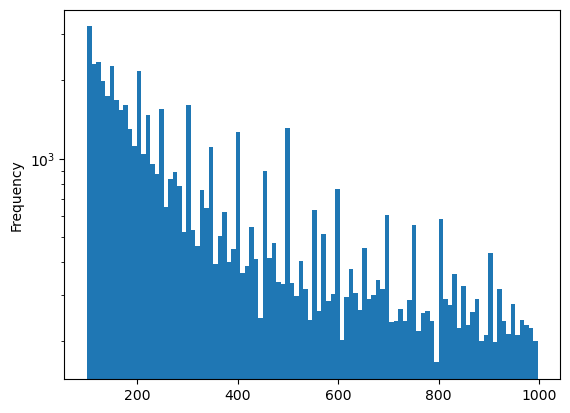

In [70]:
sf_mimicdata['fluid_out_urine__priority__mean__last_12h'].plot(kind='hist', bins=100, log=True)

In [71]:
sf_mimicdata.fluid_out_urine_source__last_12h.value_counts()

fluid_out_urine_source__last_12h
unknown    788465
FO          47557
V           13056
CC           2526
SC           1606
OR             23
PACU           15
Name: count, dtype: int64

## ureum__last__last_12h

In [72]:
sf_mimicdata.ureum__last__last_12h.describe()

count     48697.000000
mean         52.482330
std        4531.496861
min           1.000000
25%          14.000000
50%          23.000000
75%          41.000000
max      999999.000000
Name: ureum__last__last_12h, dtype: float64

In [73]:
col = 'ureum__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## creatinine__last__last_12h

In [74]:
sf_mimicdata.creatinine__last__last_12h.describe()

count     48750.000000
mean         22.069678
std        4529.096799
min           0.000000
25%           0.700000
50%           1.000000
75%           1.800000
max      999999.000000
Name: creatinine__last__last_12h, dtype: float64

In [75]:
col = 'creatinine__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## arterial_blood_pressure_mean__mean__last_12h

In [76]:
sf_mimicdata.arterial_blood_pressure_mean__mean__last_12h.describe()

count    25427.000000
mean        79.635053
std         15.979596
min        -36.000000
25%         70.692308
50%         77.333333
75%         86.500000
max        619.916667
Name: arterial_blood_pressure_mean__mean__last_12h, dtype: float64

In [77]:
col = 'arterial_blood_pressure_mean__mean__last_12h'

# Convert to numeric and replace implausible readings with NaN
sf_mimicdata[col] = pd.to_numeric(sf_mimicdata[col], errors='coerce')
sf_mimicdata.loc[(sf_mimicdata[col] < 30) | (sf_mimicdata[col] > 200), col] = np.nan

# Fill missing values with median (≈ typical MAP ~80 mm Hg)
sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)

# Re-check distribution
sf_mimicdata[col].describe()


C:\Users\snsimha\AppData\Local\Temp\ipykernel_8840\3296959166.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)


count    853248.000000
mean         77.401556
std           2.336471
min          30.285714
25%          77.333333
50%          77.333333
75%          77.333333
max         197.500000
Name: arterial_blood_pressure_mean__mean__last_12h, dtype: float64

## heart_rate__mean__last_12h

In [78]:
sf_mimicdata.heart_rate__mean__last_12h.describe()

count    74837.000000
mean        85.737187
std         16.569455
min          0.000000
25%         74.000000
50%         84.533333
75%         96.500000
max        527.500000
Name: heart_rate__mean__last_12h, dtype: float64

In [79]:
col = 'heart_rate__mean__last_12h'

# Convert to numeric safely
sf_mimicdata[col] = pd.to_numeric(sf_mimicdata[col], errors='coerce')

# Replace implausible values with NaN
sf_mimicdata.loc[(sf_mimicdata[col] < 30) | (sf_mimicdata[col] > 220), col] = np.nan

# Fill missing with median (typical resting HR ≈ 85)
sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)

# Check cleaned distribution
sf_mimicdata[col].describe()


C:\Users\snsimha\AppData\Local\Temp\ipykernel_8840\3559283118.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)


count    853248.000000
mean         84.644494
std           4.883615
min          31.500000
25%          84.538462
50%          84.538462
75%          84.538462
max         179.400000
Name: heart_rate__mean__last_12h, dtype: float64

## hemoglobin__last__last_12h

In [80]:
sf_mimicdata.hemoglobin__last__last_12h.describe()

count     44382.000000
mean         32.281431
std        4746.701639
min           2.600000
25%           8.200000
50%           9.400000
75%          11.000000
max      999999.000000
Name: hemoglobin__last__last_12h, dtype: float64

In [81]:
col = 'hemoglobin__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

## temperature__mean__last_12h

In [82]:
sf_mimicdata.temperature__mean__last_12h.describe()

count    4574.000000
mean       37.486909
std         5.424812
min         0.000000
25%        36.500000
50%        37.028992
75%        37.577778
max       100.900000
Name: temperature__mean__last_12h, dtype: float64

In [83]:
col = 'temperature__mean__last_12h'

sf_mimicdata[col] = pd.to_numeric(sf_mimicdata[col], errors='coerce')

# Replace implausible values with NaN
sf_mimicdata.loc[(sf_mimicdata[col] < 25) | (sf_mimicdata[col] > 45), col] = np.nan

# Fill missing with median (≈ 37 °C)
sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)

# Check distribution
sf_mimicdata[col].describe()


C:\Users\snsimha\AppData\Local\Temp\ipykernel_8840\2145823706.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)


count    853248.000000
mean         37.016568
std           0.068002
min          27.166667
25%          37.016667
50%          37.016667
75%          37.016667
max          44.400000
Name: temperature__mean__last_12h, dtype: float64

## activated_partial_thromboplastin_time__last__last_12h

In [84]:
sf_mimicdata.activated_partial_thromboplastin_time__last__last_12h.describe()

count     31746.000000
mean        200.161907
std       12548.590131
min           0.000000
25%          28.200000
50%          33.200000
75%          48.900000
max      999999.000000
Name: activated_partial_thromboplastin_time__last__last_12h, dtype: float64

In [85]:
col = 'activated_partial_thromboplastin_time__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

In [86]:
col = 'activated_partial_thromboplastin_time__last__last_12h'

sf_mimicdata[col] = pd.to_numeric(sf_mimicdata[col], errors='coerce')

# Replace implausibly low or high values
sf_mimicdata.loc[(sf_mimicdata[col] < 15) | (sf_mimicdata[col] > 120), col] = np.nan

# Fill missing with median (~33 s)
sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)

# Check cleaned stats
sf_mimicdata[col].describe()


C:\Users\snsimha\AppData\Local\Temp\ipykernel_8840\3439771115.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sf_mimicdata[col].fillna(sf_mimicdata[col].median(), inplace=True)


count    853248.000000
mean         33.173299
std           3.749648
min          21.600000
25%          32.900000
50%          32.900000
75%          32.900000
max         120.000000
Name: activated_partial_thromboplastin_time__last__last_12h, dtype: float64

## bicarbonate_arterial__last__last_12h

In [98]:
sf_mimicdata.bicarbonate_arterial__last__last_12h.describe()

count    48477.000000
mean        24.609140
std          4.971155
min         13.000000
25%         21.000000
50%         24.000000
75%         27.000000
max         39.000000
Name: bicarbonate_arterial__last__last_12h, dtype: float64

In [88]:
col = 'bicarbonate_arterial__last__last_12h'
lower, upper = sf_mimicdata[col].quantile([0.01, 0.99])  # 1st–99th percentile
sf_mimicdata[col] = np.clip(sf_mimicdata[col], lower, upper)

# Combine GCS

In [89]:
E = pd.to_numeric(sf_mimicdata['glasgow_coma_scale_eye__last__last_12h'], errors='coerce')
V = pd.to_numeric(sf_mimicdata['glasgow_coma_scale_verbal__last__last_12h'], errors='coerce')
M = pd.to_numeric(sf_mimicdata['glasgow_coma_scale_motor__last__last_12h'], errors='coerce')

E = E.replace(0, np.nan)
V = V.replace(0, np.nan)
M = M.replace(0, np.nan)

# Valid ranges
E = E.round().where(E.between(1, 4))
V = V.round().where(V.between(1, 5))
M = M.round().where(M.between(1, 6))

# if ventilated and Verbal is missing, set V=1 (intubation rule)
if 'vent_status__last__last_12h' in sf_mimicdata.columns:
    vent_mask = sf_mimicdata['vent_status__last__last_12h'].isin(['inv', 'ninv'])
    V = V.where(~(vent_mask & V.isna()), 1)

mask_all = E.notna() & V.notna() & M.notna()
gcs_total = (E + V + M).where(mask_all)

sf_mimicdata['glasgow_coma_scale_total__last__last_12h'] = gcs_total.fillna(15).clip(lower=3, upper=15)

In [90]:
sf_mimicdata.glasgow_coma_scale_total__last__last_12h.describe()

count    853248.000000
mean         14.741899
std           1.393897
min           3.000000
25%          15.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: glasgow_coma_scale_total__last__last_12h, dtype: float64

In [91]:
sf_mimicdata.rename(columns={"label": "icu_mortality"}, inplace=True)

In [92]:
# Sanity check to see if there are multiple stay_ids with t=0.
sf_mimicdata[sf_mimicdata["t"] == 0]["stay_id"].value_counts().gt(1).sum()

0

In [93]:
# Pick only those columns relevant for pygformula pipeline next
picked_L = [
"stay_id", "t", "los", "age", "gender", "ethnicity", "icu_mortality", "mortality_within_7days_after_discharge", "subject_id", "intime", "outtime", "insurance", 
    
    'bicarbonate_arterial__last__last_12h',
    'activated_partial_thromboplastin_time__last__last_12h',
    'temperature__mean__last_12h',

    'hemoglobin__last__last_12h',
    'heart_rate__mean__last_12h',
    'arterial_blood_pressure_mean__mean__last_12h',

    'creatinine__last__last_12h',
    'ureum__last__last_12h',
    'fluid_out_urine__priority__mean__last_12h',
    'lactate__last__last_12h',
    
    'glasgow_coma_scale_total__last__last_12h',
    
    'pco2_arterial__mean__last_12h',
    'respiratory_rate_measured__mean__last_12h',
    'o2_saturation__mean__last_12h',
    'o2_flow__last__last_12h',  
    'po2_arterial__mean__last_12h',

    'vent_status__last__last_12h',
    'vent_mode__last__last_12h',
    'vent_mode__hours_since_last__last_12h'
]

sf_mimicdata = sf_mimicdata[picked_L]

In [94]:
sf_mimicdata

,stay_id,t,los,age,gender,ethnicity,icu_mortality,mortality_within_7days_after_discharge,subject_id,intime,...,lactate__last__last_12h,glasgow_coma_scale_total__last__last_12h,pco2_arterial__mean__last_12h,respiratory_rate_measured__mean__last_12h,o2_saturation__mean__last_12h,o2_flow__last__last_12h,po2_arterial__mean__last_12h,vent_status__last__last_12h,vent_mode__last__last_12h,vent_mode__hours_since_last__last_12h
0,32332612,0,25,77,F,WHITE,0,0,11061117,2122-02-16 15:46:50,...,NaN,15.0,NaN,18.071429,95.454545,2.0,NaN,unknown,unknown,0.0
1,32332612,1,25,77,F,WHITE,0,0,11061117,2122-02-16 15:46:50,...,NaN,15.0,NaN,18.250000,97.833333,2.0,NaN,unknown,unknown,12.0
2,32332612,2,25,77,F,WHITE,0,0,11061117,2122-02-16 15:46:50,...,NaN,15.0,NaN,18.000000,96.000000,NaN,NaN,unknown,unknown,24.0
3,32332612,3,25,77,F,WHITE,0,0,11061117,2122-02-16 15:46:50,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,36.0
4,32332612,4,25,77,F,WHITE,0,0,11061117,2122-02-16 15:46:50,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853243,33318227,69,74,56,F,WHITE,0,0,15267867,2149-09-11 16:00:00,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,804.0
853244,33318227,70,74,56,F,WHITE,0,0,15267867,2149-09-11 16:00:00,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,816.0
853245,33318227,71,74,56,F,WHITE,0,0,15267867,2149-09-11 16:00:00,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,828.0
853246,33318227,72,74,56,F,WHITE,0,0,15267867,2149-09-11 16:00:00,...,NaN,15.0,NaN,NaN,NaN,NaN,NaN,unknown,unknown,840.0


In [95]:
sf_mimicdata.stay_id.nunique()

9593

In [96]:
sf_mimicdata.to_csv(r'C:\Users\snsimha\OneDrive - Amsterdam UMC\Documenten\PhD\Design Trial\Code\Self-pipeline\MIMIC-IV\Dataset\3-cut\10k_ventmode_all_organizevars_SelfPipeline.csv', index=False)

In [97]:
sf_mimicdata.stay_id.nunique()

9593